In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot
from astropy.io import fits
import os
import healpy as hp

import plotting
import auxil_ML as aux
import healpylib3 as hlib




In [2]:
def accuracy_score(y_true, y_pred):
    return np.sum(y_true == y_pred) / len(y_true)

In [3]:
plotting.setup_figure_pars()
save_plots = 1

In [4]:
if 1:
    import importlib
    importlib.reload(plotting);
    importlib.reload(aux);
    importlib.reload(hlib);

In [5]:
def min_max_vs(dct, corr={}):
    vals = np.array([dct[key] - corr.get(key, 0.) for key in dct.keys()])
    return np.min(vals, axis=0), np.max(vals, axis=0)


In [51]:
cat = '4FGL'
cat_name = cat
if cat == '4FGL':
    cat_name = '4FGL-DR2'
nclasses = 3
estr = ''
correct_other = 1

folder = '../SOM'
#cat_fn = '%s/%s_catalog_newfeats.csv' % (folder, cat)
cat_fn = '%s/%s_prob_catalog_%iclasses.csv' % (folder, cat_name, nclasses)
#cat_df0 = pd.read_csv(cat_fn, index_col=0)
cat_df = pd.read_csv(cat_fn, index_col=0)

#cat_fn = 'data/%s_prob_catalog_3class.csv' % (cat)
#cat_df = pd.read_csv(cat_fn, index_col=0)

labels = ['AGN', 'PSR', 'MIXED']
plots_folder = 'plots/Accuracies'
print(cat_df.columns)

# unweighted algorithms
algs_u = ['NN', 'LR', 'RF', 'BDT']
# oversampled algorithms
algs_o = ['NN_O', 'LR_O', 'RF_O', 'BDT_O']

algs = algs_u + algs_o

if 'GLON' not in cat_df.columns:
    #cat = '4FGL' # '3FGL', '4FGL'
    print('Get GLON from FGL catalog')
    if cat == '3FGL':
        fn_cat = '../PS_comparison/gll_psc_v16.fit' # the last release of 3FGL
    else:
        #fn_cat = '../PS_comparison/gll_psc_v22.fit' # 4FGL release from 27 May 2020
        fn_cat = '../PS_comparison/gll_psc_v27.fit' # 4FGL_DR2
    hdu_cat = fits.open(fn_cat)
    fgl_df = aux.hdu2df(hdu_cat[1], index_name='Source_Name')
    cat_df['GLON'] = fgl_df['GLON'][cat_df.index]

Index(['cos(GLON)', 'GLAT', 'ln(Energy_Flux100)', 'ln(Unc_Energy_Flux100)',
       'ln(Pivot_Energy)', 'LP_Index', 'Unc_LP_Index', 'LP_beta', 'LP_SigCurv',
       'ln(Variability_Index)', 'HR12', 'HR23', 'HR34', 'HR45', 'HR56', 'HR67',
       'Category_4FGL', 'CLASS_4FGL', 'ASSOC_FGL', 'ASSOC1', 'Flags_4FGL',
       'AGN_BDT', 'AGN_BDT_STD', 'PSR_BDT', 'PSR_BDT_STD', 'OTHER_BDT',
       'OTHER_BDT_STD', 'AGN_NN', 'AGN_NN_STD', 'PSR_NN', 'PSR_NN_STD',
       'OTHER_NN', 'OTHER_NN_STD', 'AGN_RF', 'AGN_RF_STD', 'PSR_RF',
       'PSR_RF_STD', 'OTHER_RF', 'OTHER_RF_STD', 'AGN_LR', 'AGN_LR_STD',
       'PSR_LR', 'PSR_LR_STD', 'OTHER_LR', 'OTHER_LR_STD', 'AGN_BDT_O',
       'AGN_BDT_STD_O', 'PSR_BDT_O', 'PSR_BDT_STD_O', 'OTHER_BDT_O',
       'OTHER_BDT_STD_O', 'AGN_NN_O', 'AGN_NN_STD_O', 'PSR_NN_O',
       'PSR_NN_STD_O', 'OTHER_NN_O', 'OTHER_NN_STD_O', 'AGN_RF_O',
       'AGN_RF_STD_O', 'PSR_RF_O', 'PSR_RF_STD_O', 'OTHER_RF_O',
       'OTHER_RF_STD_O', 'AGN_LR_O', 'AGN_LR_STD_O', 'PSR_LR_O',

In [52]:
#fgl_df.columns

In [53]:
#sin_glat = np.abs(np.sin(np.deg2rad(cat_df0['GLAT'])))
#glat = np.abs(cat_df0['GLAT'])
sin_glat = np.abs(np.sin(np.deg2rad(cat_df['GLAT'])))
glat = np.abs(cat_df['GLAT'])

In [54]:
masks = {}
#masks['AGN & PSR'] = (cat_df['Category_%s' % cat] == 'AGN') | (cat_df['Category_%s' % cat] == 'PSR')
for pop in ['AGN', 'PSR', 'OTHER']:
    masks[pop] = (cat_df['Category_%s' % cat] == pop)
masks['PSR any algorithm'] = masks['PSR']
masks['UNAS'] = (cat_df['Category_%s' % cat] == 'UNAS')
masks['ASSOC'] = (cat_df['Category_%s' % cat] != 'UNAS')
unas_mask = masks['UNAS']

In [55]:
if nclasses == 3:
    print(sum((cat_df['Category_Prob'] == 'OTHER') & masks['ASSOC']))
    print(sum(masks['OTHER']))

166
347


In [56]:
# GLAT distribution
nbins = 20
sin_bins_unif = np.linspace(0, 1, nbins+1)
sin_bins_unif_c = (sin_bins_unif[1:] + sin_bins_unif[:-1]) / 2.
lat_bins_unif = np.linspace(0, 90, nbins+1)
lat_bins_unif_c = (lat_bins_unif[1:] + lat_bins_unif[:-1]) / 2.
print(np.rad2deg(np.arcsin(sin_bins_unif)))

[ 0.          2.86598398  5.73917048  8.62692656 11.53695903 14.47751219
 17.45760312 20.48731511 23.57817848 26.74368395 30.         33.36701297
 36.86989765 40.54160187 44.427004   48.59037789 53.13010235 58.21166938
 64.15806724 71.80512766 90.        ]


In [57]:
pcat_SP = pd.read_csv('data/FGL3_results.csv', index_col='Source_Name')
pcat_SP.index = ['3FGL %s' %name.strip() for name in pcat_SP.index]
unass_lat_SP = {}
algs0_SP = ['RF', 'LR']
unas_mask_SP = pcat_SP['CLASS1'].copy()
unas_mask_SP[:] = [type(pcat_SP['CLASS1'].iloc[i]) != str for i in range(len(unas_mask_SP))]
sin_glat_SP = np.abs(np.sin(np.deg2rad(pcat_SP['GLAT'])))
glat_SP = np.abs(pcat_SP['GLAT'])
glon_SP = pcat_SP['GLON'] - 360 * (pcat_SP['GLON'] // 180)

In [58]:
# correction for other sources
other_fgl_corr_unas = {}
other_fgl_corr_assoc = {}
bins = sin_bins_unif
other_values_fgl = sin_glat[masks['OTHER']]
hist_all_assoc_fgl = np.histogram(sin_glat[masks['ASSOC']], bins=bins)
hist_all_unassoc_fgl = np.histogram(sin_glat[masks['UNAS']], bins=bins)
unas_other_model_2classes = 1. * np.histogram(other_values_fgl, bins=bins)[0]
unas_other_model_2classes *= hist_all_unassoc_fgl[0] / (hist_all_assoc_fgl[0] + 0.00001)


for pop in ['AGN', 'PSR', 'OTHER'][:nclasses]:
    other_fgl_corr_unas[pop] = {}
    other_fgl_corr_assoc[pop] = {}

    hist_class_fgl = np.histogram(sin_glat[masks[pop]], bins=bins)

    for alg in algs:
        label = '%s_%s' % (pop, alg)
        probs = cat_df.loc[masks['OTHER'], label]
        hist_other_fgl = np.histogram(other_values_fgl, bins=bins, weights=probs)
        if correct_other and nclasses == 2:
            other_fgl_corr_unas[pop][alg] = hist_other_fgl[0]/(hist_all_assoc_fgl[0] + 0.00001) * \
                        hist_all_unassoc_fgl[0]
            other_fgl_corr_assoc[pop][alg] = hist_other_fgl[0]
        else:
            other_fgl_corr_unas[pop][alg] = np.zeros_like(hist_other_fgl[0])
            other_fgl_corr_assoc[pop][alg] = np.zeros_like(hist_other_fgl[0])

if cat == '3FGL':
    other_SP_corr_unas = {}
    other_SP_corr_assoc = {}
    for pop in ['AGN', 'PSR']:
        other_SP_corr_unas[pop] = {}
        other_SP_corr_assoc[pop] = {}
        for alg in algs0_SP:
            label = '%s_P' % (alg)
            other_fgl_sources = [name for name in cat_df.index if masks['OTHER'][name]]
            other_fgl_sources_SP = [name for name in other_fgl_sources if name in pcat_SP.index]
            probs = pcat_SP.loc[other_fgl_sources_SP, label]
            #print(len(other_fgl_sources_SP), len(probs))
            #probs = pcat_SP.loc[masks['OTHER'], label]
            hist_other_SP = np.histogram(other_values_fgl[other_fgl_sources_SP], bins=bins, weights=probs)
            if correct_other:
                other_SP_corr_unas[pop][alg] = hist_other_SP[0]/(hist_all_assoc_fgl[0] + 0.00001) * \
                            hist_all_unassoc_fgl[0]
                other_SP_corr_assoc[pop][alg] = hist_other_SP[0]
            else:
                other_SP_corr_unas[pop][alg] = np.zeros_like(hist_other_SP[0])
                other_SP_corr_assoc[pop][alg] = np.zeros_like(hist_other_SP[0])



In [59]:
print(np.sum(unas_other_model_2classes), np.sum(np.histogram(other_values_fgl, bins=bins)[0]))

319.1625951142059 347


save figure to file: plots/Accuracies/lat_profile_AGN_4FGL-DR2_3classes.pdf
cp plots/Accuracies/lat_profile_AGN_4FGL-DR2_3classes.pdf ../ML_3FGL_paper/plots
cp plots/Accuracies/lat_profile_AGN_4FGL-DR2_3classes.pdf ../ML_3FGL_paper_AA_style/plots

Number of AGN: $948.0^{+122.7}_{-135.8}$
N other model: 319.2
save figure to file: plots/Accuracies/lat_profile_PSR_4FGL-DR2_3classes.pdf
cp plots/Accuracies/lat_profile_PSR_4FGL-DR2_3classes.pdf ../ML_3FGL_paper/plots
cp plots/Accuracies/lat_profile_PSR_4FGL-DR2_3classes.pdf ../ML_3FGL_paper_AA_style/plots

Number of PSR: $214.9^{+47.0}_{-41.8}$
N other model: 319.2
save figure to file: plots/Accuracies/lat_profile_OTHER_4FGL-DR2_3classes.pdf
cp plots/Accuracies/lat_profile_OTHER_4FGL-DR2_3classes.pdf ../ML_3FGL_paper/plots
cp plots/Accuracies/lat_profile_OTHER_4FGL-DR2_3classes.pdf ../ML_3FGL_paper_AA_style/plots

Number of OTHER: $504.1^{+88.9}_{-102.6}$
N other model: 319.2


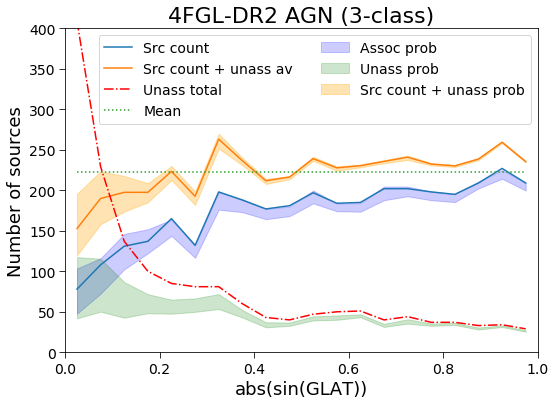

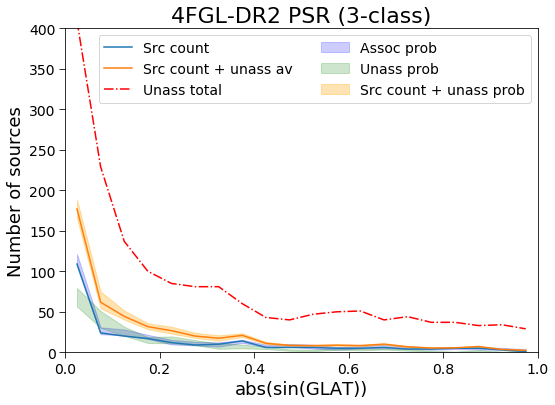

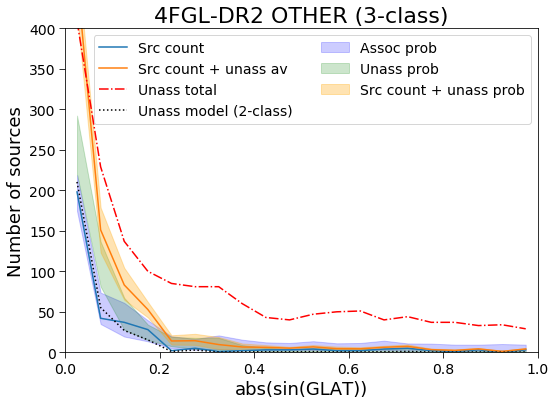

In [60]:
SP_colors = ['violet', 'brown']
SP_lss = ['--', ':']
use_sin_glat = 1
#plotting.setup_figure_pars()
#print(pyplot.rcParams['figure.subplot.left'])
#pyplot.rcParams['figure.subplot.bottom'] = 0.15
unass_lat_tot = np.histogram(sin_glat[unas_mask], bins=sin_bins_unif)[0]
for pop in ['AGN', 'PSR', 'OTHER'][:nclasses]:
    ass_lat = np.histogram(sin_glat[masks[pop]], bins=sin_bins_unif)[0]
    unass_lat = {}
    assoc_lat = {}
    unass_lat_av = np.zeros(nbins)
    for alg in algs:
        unass_lat[alg] = np.histogram(sin_glat[unas_mask], bins=sin_bins_unif, 
                                          weights=cat_df['%s_%s' % (pop, alg)][unas_mask])[0]
        unass_lat[alg] -= other_fgl_corr_unas[pop][alg]
        assoc_lat[alg] = np.histogram(sin_glat[~unas_mask], bins=sin_bins_unif, 
                                          weights=cat_df['%s_%s' % (pop, alg)][~unas_mask])[0]
        assoc_lat[alg] -= other_fgl_corr_assoc[pop][alg]
        unass_lat_av += unass_lat[alg] / len(algs)
            
    if cat == '3FGL' and pop in ['PSR', 'AGN']:
        for alg in algs0_SP:
            if pop == 'PSR':
                weights = pcat_SP['%s_P' % alg][unas_mask_SP]
            elif pop == 'AGN':
                weights = 1 - pcat_SP['%s_P' % alg][unas_mask_SP]
                
            unass_lat_SP[alg] = np.histogram(sin_glat_SP[unas_mask_SP], bins=sin_bins_unif, 
                                          weights=weights)[0]
            unass_lat_SP[alg] -= other_SP_corr_assoc[pop][alg]
                
    xs = sin_bins_unif_c
    
    fig = pyplot.figure()
    pyplot.plot(xs, ass_lat, label='Src count')
    minvs, maxvs = min_max_vs(assoc_lat)
    pyplot.fill_between(xs, minvs, maxvs, color='blue', alpha=0.2, label='Assoc prob')


    minvs, maxvs = min_max_vs(unass_lat)
    pyplot.fill_between(xs, minvs, maxvs, color='green', alpha=0.2, label='Unass prob')
    pyplot.fill_between(xs, ass_lat + minvs, ass_lat + maxvs, color='orange', alpha=0.3, 
                        label='Src count + unass prob')
    
    mean = np.mean(ass_lat + unass_lat_av) * np.ones(nbins)
    pyplot.plot(xs, ass_lat + unass_lat_av, label='Src count + unass av')
    #pyplot.errorbar(xs, ass_lat + unass_lat_av, np.sqrt(mean), ls='', marker='s', label='Assoc + Unassoc av.')
    pyplot.plot(xs, unass_lat_tot, ls='-.', color='r', label='Unass total')
    

    if pop == 'AGN':
        pyplot.plot(xs, mean, ls=':', label='Mean')
    if cat == '3FGL' and pop in ['PSR', 'AGN']:
        for i, alg in enumerate(algs0_SP):
            pyplot.plot(xs, unass_lat_SP[alg], ls=SP_lss[i], c='gray', #c=SP_colors[i], 
                        label='Unass prob %s (SP16)' % alg)

    if pop == 'OTHER':
        pyplot.plot(xs, unas_other_model_2classes, ls=':', color='black', label='Unass model (2-class)')
        
    pyplot.title('%s %s (%i-class)' %(cat_name, pop, nclasses))
    pyplot.legend(ncol=2)
    #pyplot.grid()
    if use_sin_glat:
        pyplot.xlabel('abs(sin(GLAT))')
        pyplot.xlim(0, 1)
        #x_ticks = fig.axes[0].get_xticks()
        #x_ticks_new = np.around(np.rad2deg(np.arcsin(x_ticks)))
        #fig.axes[0].set_xticks(x_ticks_new)
    else:
        pyplot.xlabel('abs(GLAT)')
        pyplot.xlim(0, 90)
        
    pyplot.ylabel('Number of sources')
    if cat == '3FGL':
        pyplot.ylim(0, 300)
    elif cat == '4FGL':
        pyplot.ylim(0, 400)

    if save_plots:
        #fn = '%s/lat_profile_%s_%s%s.pdf' % (plots_folder, pop, cat_name, estr)
        fn = '%s/lat_profile_%s_%s%s_%iclasses.pdf' % (plots_folder, pop, cat_name, estr, nclasses)
        print('save figure to file: %s' % fn)
        pyplot.savefig(fn)
        if 1:
            cmd = 'cp %s ../ML_3FGL_paper/plots' % fn
            print(cmd)
            os.system(cmd)
            cmd = 'cp %s ../ML_3FGL_paper_AA_style/plots' % fn
            print(cmd)
            os.system(cmd)
            
    pred = [np.sum(unass_lat[alg]) for alg in algs]
    mean, delta_plus, delta_minus = aux.get_mean_dp_dm(pred)
    print('\nNumber of %s: $%.1f^{+%.1f}_{-%.1f}$' % (pop, mean, delta_plus, delta_minus))
    print('N other model: %.1f' % np.sum(unas_other_model_2classes))

In [61]:
if 0:
    x_ticks = fig.axes[0].get_xticks()
    x_ticks_new = np.around(np.rad2deg(np.arcsin(x_ticks)))
    print(x_ticks, x_ticks_new)

In [62]:
nbins_lon = 30
glon_bins = np.linspace(-180, 180, nbins_lon + 1)
glon_bins_c = (glon_bins[1:] + glon_bins[:-1]) / 2.
# make the range from -180 to 180
#glon = cat_df0['GLON'] - 360. * (cat_df0['GLON'] // 180.)
glon = cat_df['GLON'] - 360. * (cat_df['GLON'] // 180.)


In [63]:
# correction for other sources
other_fgl_corr_unas = {}
other_fgl_corr_assoc = {}
bins = glon_bins
other_values_fgl = glon[masks['OTHER']]
hist_all_assoc_fgl = np.histogram(glon[masks['ASSOC']], bins=bins)
hist_all_unassoc_fgl = np.histogram(glon[masks['UNAS']], bins=bins)
unas_other_model_2classes = 1. * np.histogram(other_values_fgl, bins=bins)[0]
unas_other_model_2classes *= hist_all_unassoc_fgl[0] / (hist_all_assoc_fgl[0] + 0.00001)


for pop in ['AGN', 'PSR', 'OTHER'][:nclasses]:
    other_fgl_corr_unas[pop] = {}
    other_fgl_corr_assoc[pop] = {}

    hist_class_fgl = np.histogram(glon[masks[pop]], bins=bins)

    for alg in algs:
        label = '%s_%s' % (pop, alg)
        probs = cat_df.loc[masks['OTHER'], label]
        hist_other_fgl = np.histogram(other_values_fgl, bins=bins, weights=probs)
        if correct_other and nclasses == 2:
            other_fgl_corr_unas[pop][alg] = hist_other_fgl[0]/(hist_all_assoc_fgl[0] + 0.00001) * \
                        hist_all_unassoc_fgl[0]
            other_fgl_corr_assoc[pop][alg] = hist_other_fgl[0]
        else:
            other_fgl_corr_unas[pop][alg] = np.zeros_like(hist_other_fgl[0])
            other_fgl_corr_assoc[pop][alg] = np.zeros_like(hist_other_fgl[0])

if cat == '3FGL':
    other_SP_corr_unas = {}
    other_SP_corr_assoc = {}
    for pop in ['AGN', 'PSR']:
        other_SP_corr_unas[pop] = {}
        other_SP_corr_assoc[pop] = {}
        for alg in algs0_SP:
            label = '%s_P' % (alg)
            other_fgl_sources = [name for name in cat_df.index if masks['OTHER'][name]]
            other_fgl_sources_SP = [name for name in other_fgl_sources if name in pcat_SP.index]
            probs = pcat_SP.loc[other_fgl_sources_SP, label]
            hist_other_SP = np.histogram(other_values_fgl[other_fgl_sources_SP], bins=bins, weights=probs)
            if correct_other:
                other_SP_corr_unas[pop][alg] = hist_other_SP[0]/(hist_all_assoc_fgl[0] + 0.00001) * \
                            hist_all_unassoc_fgl[0]
                other_SP_corr_assoc[pop][alg] = hist_other_SP[0]
            else:
                other_SP_corr_unas[pop][alg] = np.zeros_like(hist_other_SP[0])
                other_SP_corr_assoc[pop][alg] = np.zeros_like(hist_other_SP[0])



In [64]:
print(np.sum(unas_other_model_2classes), np.sum(np.histogram(other_values_fgl, bins=bins)[0]))

195.9919017152586 347


save figure to file: plots/Accuracies/lon_profile_AGN_4FGL-DR2_3classes.pdf
cp plots/Accuracies/lon_profile_AGN_4FGL-DR2_3classes.pdf ../ML_3FGL_paper/plots
cp plots/Accuracies/lon_profile_AGN_4FGL-DR2_3classes.pdf ../ML_3FGL_paper_AA_style/plots

Number of AGN: $948.0^{+122.7}_{-135.8}$
N other model: 196.0
save figure to file: plots/Accuracies/lon_profile_PSR_4FGL-DR2_3classes.pdf
cp plots/Accuracies/lon_profile_PSR_4FGL-DR2_3classes.pdf ../ML_3FGL_paper/plots
cp plots/Accuracies/lon_profile_PSR_4FGL-DR2_3classes.pdf ../ML_3FGL_paper_AA_style/plots

Number of PSR: $214.9^{+47.0}_{-41.8}$
N other model: 196.0
save figure to file: plots/Accuracies/lon_profile_OTHER_4FGL-DR2_3classes.pdf
cp plots/Accuracies/lon_profile_OTHER_4FGL-DR2_3classes.pdf ../ML_3FGL_paper/plots
cp plots/Accuracies/lon_profile_OTHER_4FGL-DR2_3classes.pdf ../ML_3FGL_paper_AA_style/plots

Number of OTHER: $504.1^{+88.9}_{-102.6}$
N other model: 196.0


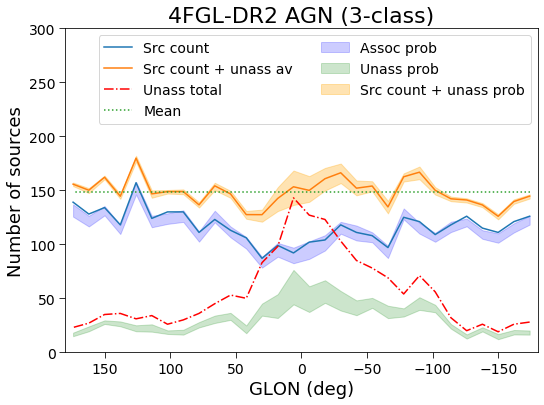

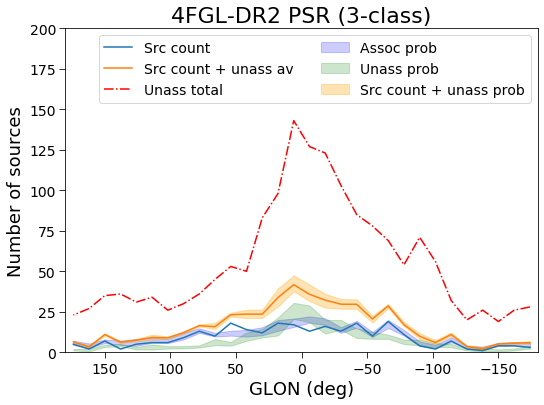

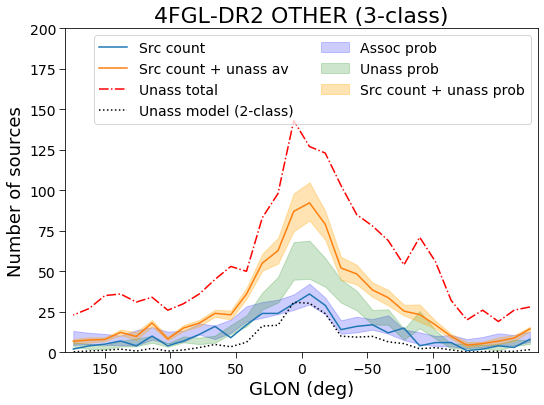

In [65]:

unass_lon_tot = np.histogram(glon[unas_mask], bins=glon_bins)[0]
for pop in ['AGN', 'PSR', 'OTHER'][:nclasses]:
    ass_lon = np.histogram(glon[masks[pop]], bins=glon_bins)[0]
    unass_lon = {}
    assoc_lon = {}
    unass_lon_SP = {}
    unass_lon_av = np.zeros(nbins_lon)
        
    for alg in algs:
        unass_lon[alg] = np.histogram(glon[unas_mask], bins=glon_bins, 
                                          weights=cat_df['%s_%s' % (pop, alg)][unas_mask])[0]
        unass_lon[alg] -= other_fgl_corr_unas[pop][alg]
        unass_lon_av += (unass_lon[alg]) / len(algs)
        assoc_lon[alg] = np.histogram(glon[~unas_mask], bins=glon_bins, 
                                          weights=cat_df['%s_%s' % (pop, alg)][~unas_mask])[0]
        assoc_lon[alg] -= other_fgl_corr_assoc[pop][alg]

        
    if cat == '3FGL' and pop in ['PSR', 'AGN']:
        for alg in algs0_SP:
            if pop == 'PSR':
                weights = pcat_SP['%s_P' % alg][unas_mask_SP]
            elif pop == 'AGN':
                weights = 1 - pcat_SP['%s_P' % alg][unas_mask_SP]
            unass_lon_SP[alg] = np.histogram(glon_SP[unas_mask_SP], bins=glon_bins, 
                                              weights=weights)[0]
            unass_lon_SP[alg] -= other_SP_corr_unas[pop][alg]

    xs = glon_bins_c
    pyplot.figure()
    pyplot.plot(xs, ass_lon, label='Src count')
    minvs, maxvs = min_max_vs(assoc_lon)
    pyplot.fill_between(xs, minvs, maxvs, color='blue', alpha=0.2, label='Assoc prob')

    minvs, maxvs = min_max_vs(unass_lon)
    pyplot.fill_between(xs, minvs, maxvs, color='green', alpha=0.2, label='Unass prob')
    pyplot.fill_between(xs, ass_lon + minvs, ass_lon + maxvs, color='orange', alpha=0.3, 
                        label='Src count + unass prob')

    
    mean = np.mean(ass_lon + unass_lon_av) * np.ones(nbins_lon)
    pyplot.plot(xs, ass_lon + unass_lon_av, label='Src count + unass av')
    #pyplot.errorbar(xs, ass_lat + unass_lat_av, np.sqrt(mean), ls='', marker='s', label='Assoc + Unassoc av.')
    pyplot.plot(xs, unass_lon_tot, ls='-.', color='r', label='Unass total')
    

    if pop == 'AGN':
        pyplot.plot(xs, mean, ls=':', label='Mean')

    if cat == '3FGL' and pop in ['PSR', 'AGN']:
        for i, alg in enumerate(algs0_SP):
            pyplot.plot(xs, unass_lon_SP[alg], ls=SP_lss[i], c='gray', #c=SP_colors[i], 
                        label='Unass prob %s (SP16)' % alg)
    if pop == 'OTHER':
        pyplot.plot(xs, unas_other_model_2classes, ls=':', color='black', label='Unass model (2-class)')

    pyplot.title('%s %s (%i-class)' %(cat_name, pop, nclasses))
    pyplot.legend(ncol=2)
    #pyplot.grid()
    pyplot.xlabel('GLON (deg)')
    pyplot.ylabel('Number of sources')
    pyplot.xlim(180, -180)
    if cat == '4FGL':
        if pop == 'AGN':
            pyplot.ylim(0, 300)
        else:
            pyplot.ylim(0, 200)
    else:
        if pop == 'AGN':
            pyplot.ylim(0, 180)
        else:
            pyplot.ylim(0, 100)
        
            
    if save_plots:
        fn = '%s/lon_profile_%s_%s%s_%iclasses.pdf' % (plots_folder, pop, cat_name, estr, nclasses)
        print('save figure to file: %s' % fn)
        pyplot.savefig(fn)
        cmd = 'cp %s ../ML_3FGL_paper/plots' % fn
        print(cmd)
        os.system(cmd)
        cmd = 'cp %s ../ML_3FGL_paper_AA_style/plots' % fn
        print(cmd)
        os.system(cmd)
    
    pred = [np.sum(unass_lon[alg]) for alg in algs]
    mean, delta_plus, delta_minus = aux.get_mean_dp_dm(pred)
    print('\nNumber of %s: $%.1f^{+%.1f}_{-%.1f}$' % (pop, mean, delta_plus, delta_minus))
    print('N other model: %.1f' % np.sum(unas_other_model_2classes))